In [ ]:
pip install pyqt5

     |████████████████████████████████| 8.3MB 3.9MB/s 
     |████████████████████████████████| 317kB 26.2MB/s 
     |████████████████████████████████| 59.9MB 90kB/s 


In [ ]:
import dlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
import numpy as np

In [3]:
detector = dlib.get_frontal_face_detector() # 얼굴 영역 인식 모델 로드
sp = dlib.shape_predictor('/content/drive/MyDrive/test/dl/beautyGAN/models/shape_predictor_5_face_landmarks.dat') 

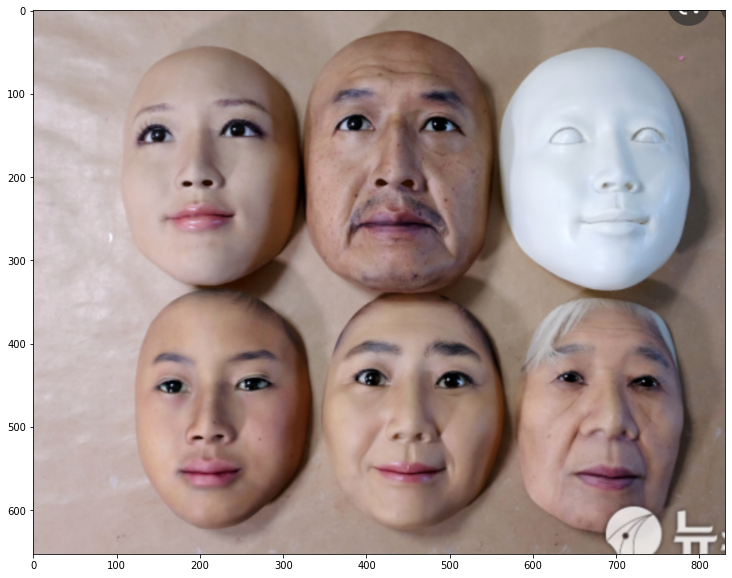

In [4]:
img = dlib.load_rgb_image('/content/drive/MyDrive/test/dl/beautyGAN/캡처.PNG') # 이미지를 로드한다
plt.figure(figsize = (16, 10)) 
plt.imshow(img)

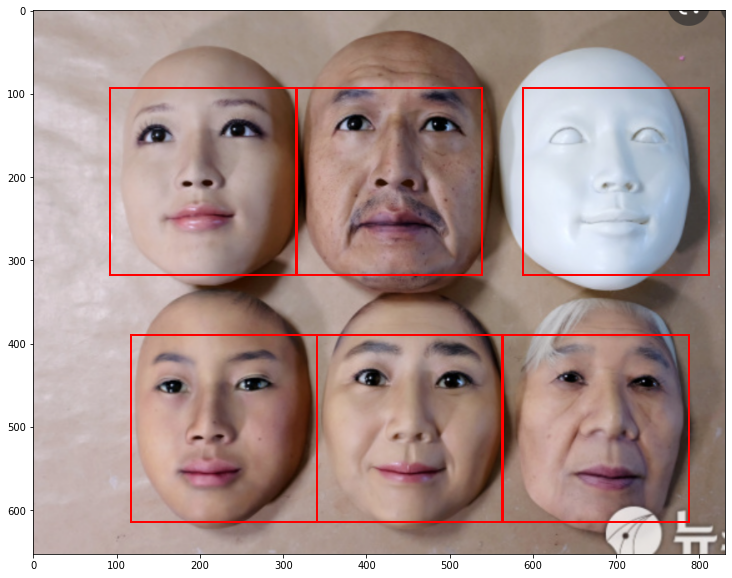

In [5]:
img_result = img.copy()
dets = detector(img, 1)

if len(dets) == 0:
    print('cannot find faces!')
    
fig, ax = plt.subplots(1, figsize=(16, 10))

for det in dets:
    x, y, w, h = det.left(), det.top(), det.width(), det.height()
    
    rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

ax.imshow(img_result)

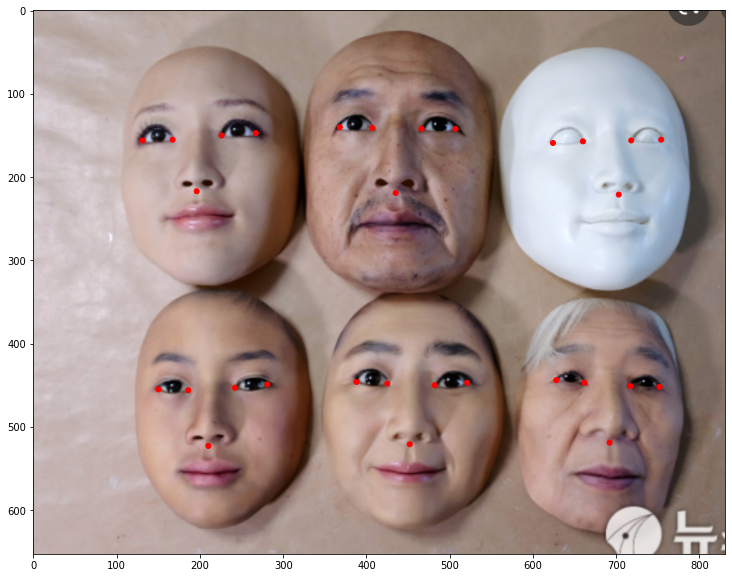

In [6]:
fig, ax = plt.subplots(1, figsize=(16, 10))
objs = dlib.full_object_detections()

for detection in dets:
    s = sp(img, detection) # 얼굴의 랜드마크를 찾는다
    objs.append(s)
    
    for point in s.parts():
        circle = patches.Circle((point.x, point.y), radius=3, edgecolor='r', facecolor='r') # patches.Circle : 원을 그린다
        ax.add_patch(circle)

ax.imshow(img_result)

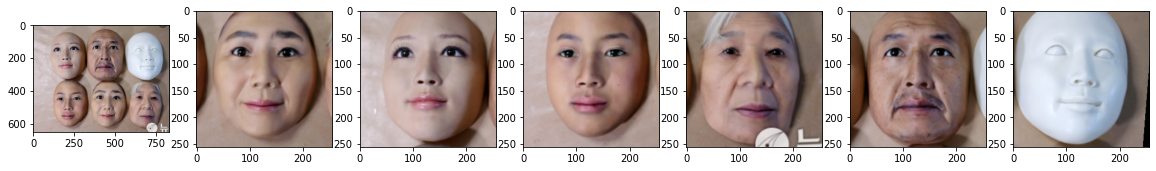

In [7]:
faces = dlib.get_face_chips(img, objs, size=256, padding=0.3) # dlib.get_face_chips : 얼굴을 수평으로 회전하여 얼굴 부분만 자른 이미지를 반환
fig, axes = plt.subplots(1, len(faces)+1, figsize=(20, 16))
axes[0].imshow(img)

for i, face in enumerate(faces):
    axes[i+1].imshow(face)

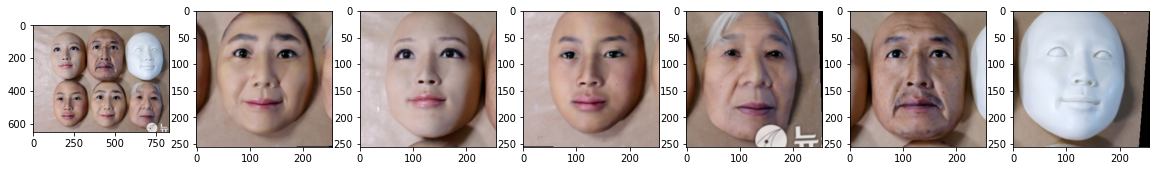

In [9]:
def align_faces(img):
    dets = detector(img, 1)
    objs = dlib.full_object_detections()
    
    for detection in dets:
        s = sp(img, detection)
        objs.append(s)
        
    faces = dlib.get_face_chips(img, objs, size=256, padding=0.35)
    
    return faces

# test
test_img = dlib.load_rgb_image('/content/drive/MyDrive/test/dl/beautyGAN/캡처.PNG')
test_faces = align_faces(test_img)
fig, axes = plt.subplots(1, len(test_faces)+1, figsize=(20, 16))
axes[0].imshow(test_img)

for i, face in enumerate(test_faces):
    axes[i+1].imshow(face)

In [10]:
tf.compat.v1.disable_eager_execution()
sess = tf.compat.v1.Session()
sess.run(tf.compat.v1.global_variables_initializer())

saver = tf.compat.v1.train.import_meta_graph('/content/drive/MyDrive/test/dl/beautyGAN/models/model.meta')
saver.restore(sess, tf.train.latest_checkpoint('/content/drive/MyDrive/test/dl/beautyGAN/models'))
graph = tf.compat.v1.get_default_graph()

X = graph.get_tensor_by_name('X:0') # source
Y = graph.get_tensor_by_name('Y:0') # reference
Xs = graph.get_tensor_by_name('generator/xs:0') # output

INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/test/dl/beautyGAN/models/model


In [11]:
def preprocess(img):
    return img.astype(np.float32) / 127.5-1.
def postprocess(img):
    return ((img + 1.) * 127.5).astype(np.uint8)

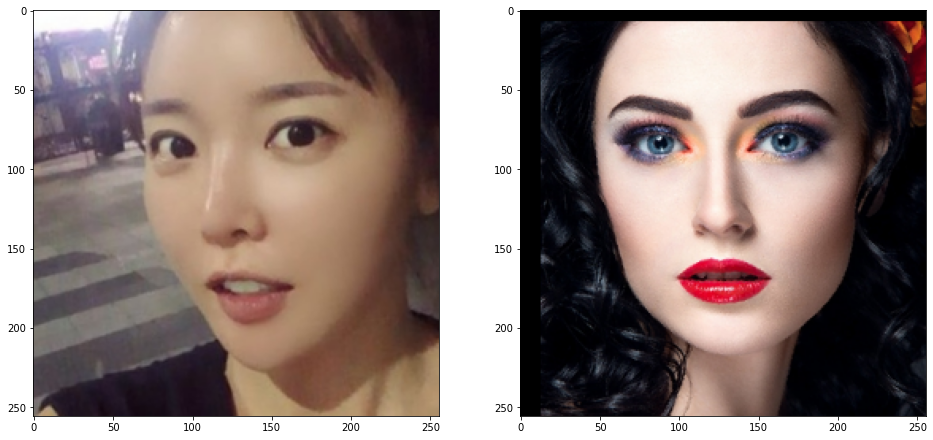

In [24]:
img1 = dlib.load_rgb_image('/content/drive/MyDrive/test/dl/beautyGAN/nomakeup/12.jpg')
img1_faces = align_faces(img1)

img2 = dlib.load_rgb_image('/content/drive/MyDrive/test/dl/beautyGAN/makeup/XMY-014.png')
img2_faces = align_faces(img2)

fig, axes = plt.subplots(1, 2, figsize=(16, 10))
axes[0].imshow(img1_faces[0])
axes[1].imshow(img2_faces[0])

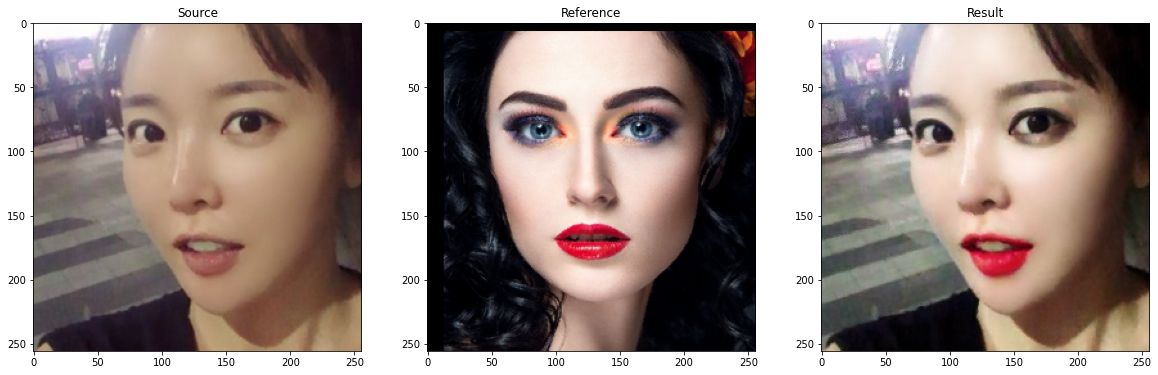

In [25]:
src_img = img1_faces[0]
ref_img = img2_faces[0]

X_img = preprocess(src_img)
X_img = np.expand_dims(X_img, axis=0) # 배열에 차원을 추가, 0번 axis는 배치 방향

Y_img = preprocess(ref_img)
Y_img = np.expand_dims(Y_img, axis=0)

output = sess.run(Xs, feed_dict={
    X: X_img,
    Y: Y_img
})

output_img = postprocess(output[0])
fig, axes = plt.subplots(1, 3, figsize=(20, 10))
axes[0].set_title('Source')
axes[0].imshow(src_img)
axes[1].set_title('Reference')
axes[1].imshow(ref_img)
axes[2].set_title('Result')
axes[2].imshow(output_img)